Copyright 2024 Hewlett Packard Enterprise Development LP.

## Analysis of Simulations



# Remove the cpu.all from the pmdumptext and use cpu.all.local

In [1]:
# Import libraries
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
#library(gridExtra)
library(patchwork)
library(RColorBrewer)
library(scales)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


── Attaching core tidyverse packages ───────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ lubridate 1.9.3     ✔ stringr   1.5.0
✔ purrr     1.0.2     ✔ tibble    3.2.1
── Conflicts ─────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ readr::col_factor()   masks scales::col_factor()
✖ purrr::discard()      masks scales::discard()
✖ dplyr::filter()       masks stats::filter()
✖ data.table::first()   masks dplyr::first()
✖ lubridate::hour()     masks data.table::hour()
✖ lubridate::isoweek()  masks data.table::isoweek()
✖ dplyr::la

## Creating Functions

column_names <-c("or", "d", "ddate", "rdate", "changes", "class", "price", "fdate", "company", "number", "dur", "added", "source", "key") 
column_classes <- c("factor", "factor", "factor", "factor", "integer", "factor", "integer", "factor", "factor", "factor", "integer", "factor", "factor", "NULL") 

data <- fread(zz3, header = FALSE, sep = ",", skip = 1, na.strings = c(""), colClasses = column_classes)
setnames(data, column_names)

In [2]:
# Create function to read and combine all csv files
read_and_bind_all_files <- function(path, pattern = "*.csv") {
    files = list.files(path, pattern, full.names = TRUE)
    rbindlist(
        lapply(files, 
            function(x) {
                exp <- strsplit(x, split = "/")[[1]][6]
                #print(exp)
                # "gromacs_" + str(n_cores) + "_" + str(n_parallel_invokations) + "_" + str(exec_id) + "_" + str(repetition_id)
                # "log_gromacs_80_10_8_1_1.log.csv"
                name <- strsplit(exp, split = "-")[[1]][1]
                size <- strsplit(exp, split = "-")[[1]][2]
                #size <- as.integer(strsplit(strsplit(exp, split = "-")[[1]][2], split = "\\.")[[1]][1]) #here I needed to remove the .log.csv
                #cpu_work <- as.integer(strsplit(strsplit(exp, split = "-")[[1]][3], split = "_")[[1]][1]) #here I needed to remove the .log.csv
                
                t <- fread(x, header = FALSE, fill=TRUE, sep=',', skip = 1)
                t$name <- name
                t$size <- size
                #t$cpu_work <- cpu_work
                #t$seed <- seed
                t
            }
        ),fill=TRUE)
}

## Reading and Processing Files

### Scheduling Time and Makespan from Simulations

In [3]:
df_all_functions_invocation <- read_and_bind_all_files(
    paste('./wfbench/csv/functions_invocation/',sep=','))
names(df_all_functions_invocation) <- c("phase","functions","name", "size")
head(df_all_functions_invocation)
tail(df_all_functions_invocation)
print(df_all_functions_invocation)

phase functions name        size
1 0       1       BlastRecipe 250 
2 1       1       BlastRecipe 250 
3 2     245       BlastRecipe 250 
4 3       2       BlastRecipe 250 
5 4       1       BlastRecipe 250 
6 0       1       BlastRecipe 500

phase functions name            size
1 0       1       SrasearchRecipe 500 
2 1     240       SrasearchRecipe 500 
3 2     239       SrasearchRecipe 500 
4 3      17       SrasearchRecipe 500 
5 4       1       SrasearchRecipe 500 
6 5       1       SrasearchRecipe 500

     phase functions            name size
  1:     0         1     BlastRecipe  250
  2:     1         1     BlastRecipe  250
  3:     2       245     BlastRecipe  250
  4:     3         2     BlastRecipe  250
  5:     4         1     BlastRecipe  250
 ---                                     
126:     1       240 SrasearchRecipe  500
127:     2       239 SrasearchRecipe  500
128:     3        17 SrasearchRecipe  500
129:     4         1 SrasearchRecipe  500
130:     5         1 SrasearchRecipe  500


In [4]:
palette_colors <- brewer.pal(9, "Blues")[4:9]

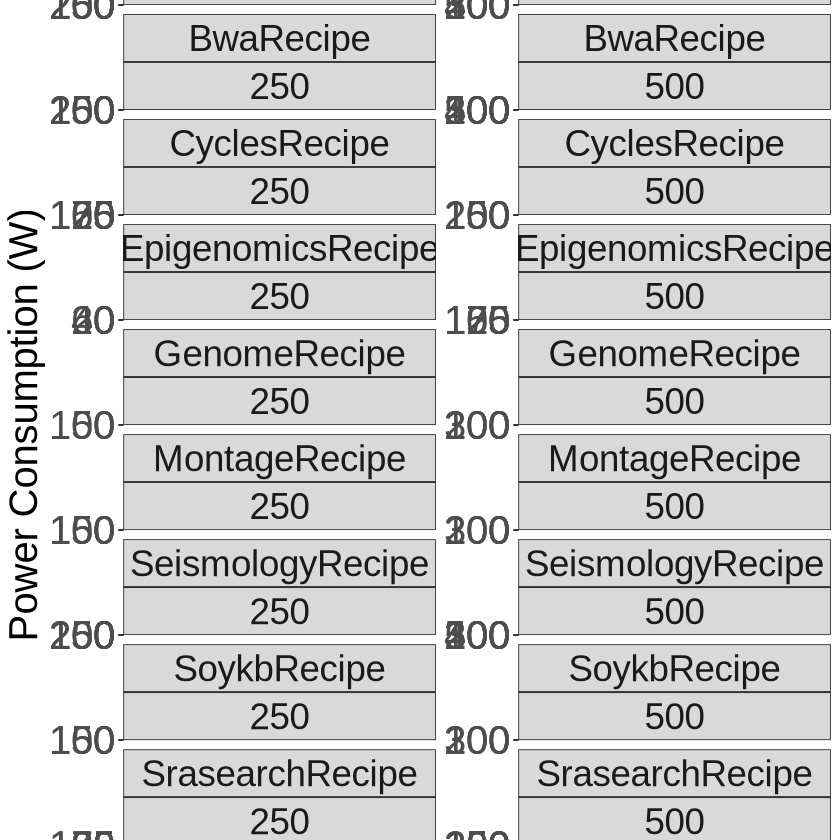

In [5]:
df_plot <- df_all_functions_invocation
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions)) + #, shape=p_size)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        labs(x = "Number of Tasks in the Workflow", y = "Power Consumption (W)", fill = "Workflows") +
        #labs(x = "Number of Tasks in the Workflow", y = "", fill = "Workflows") +
        #scale_fill_manual(values=palette_colors, labels = label_paradigm) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

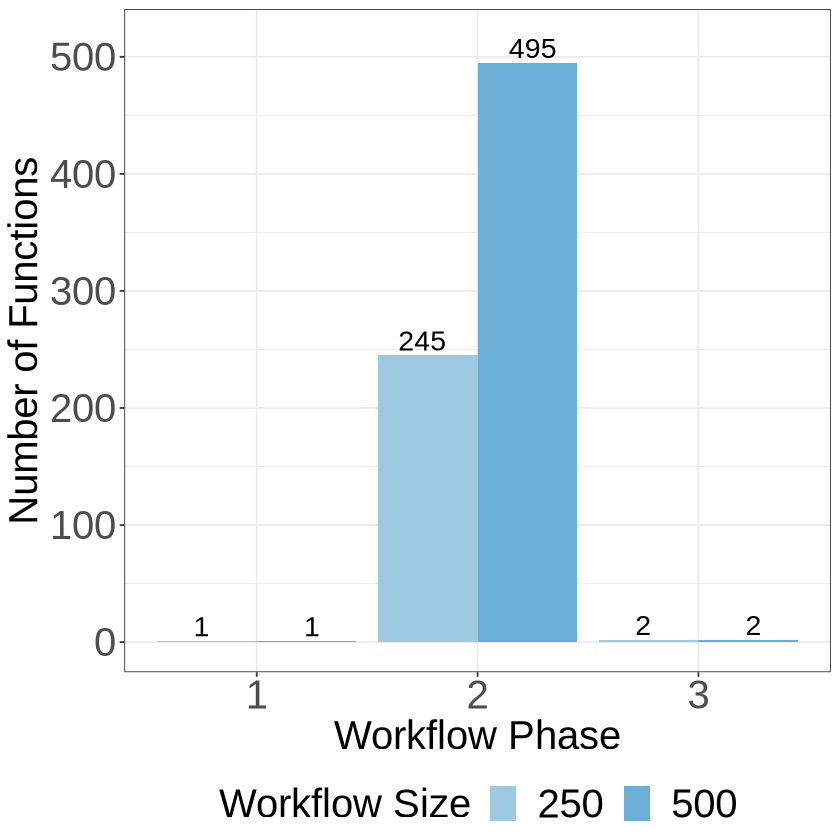

In [6]:
df_plot <- df_all_functions_invocation %>% filter(name == 'BlastRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        expand_limits(y = max(df_plot$functions) + 20) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_BlastRecipe.png", width = 8, height = 12, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

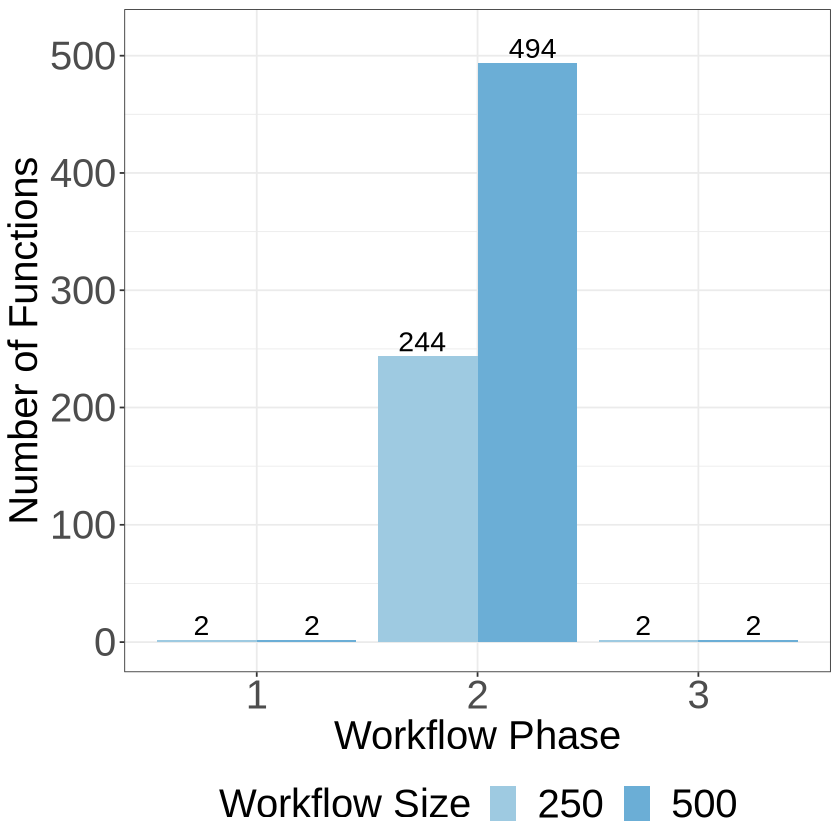

In [7]:
df_plot <- df_all_functions_invocation %>% filter(name == 'BwaRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        expand_limits(y = max(df_plot$functions) + 20) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_BwaRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

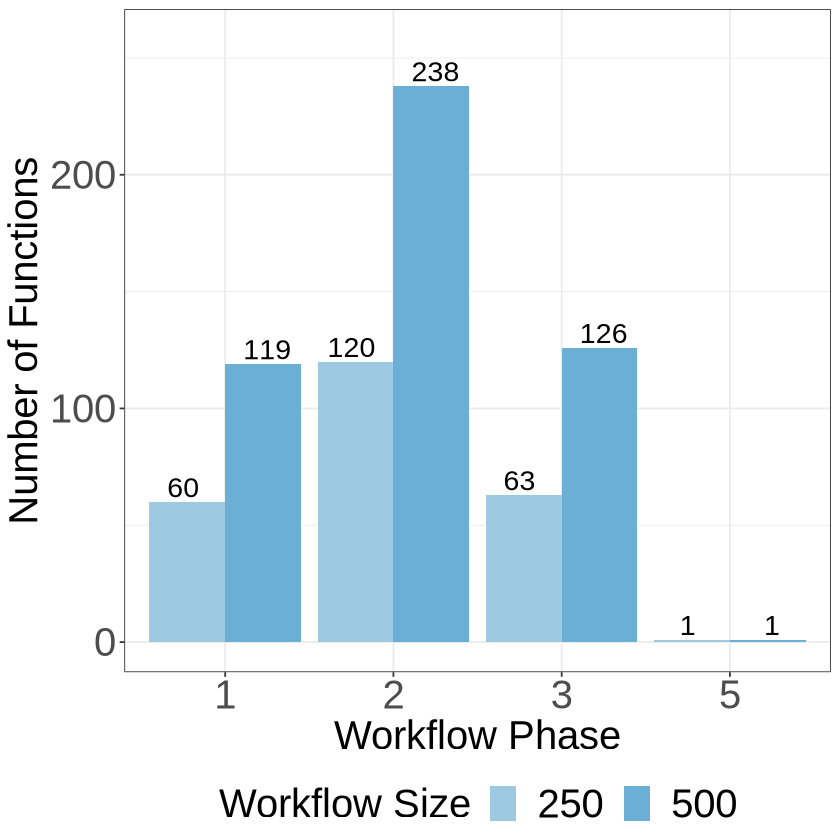

In [8]:
df_plot <- df_all_functions_invocation %>% filter(name == 'CyclesRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        expand_limits(y = max(df_plot$functions) + 20) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_CyclesRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

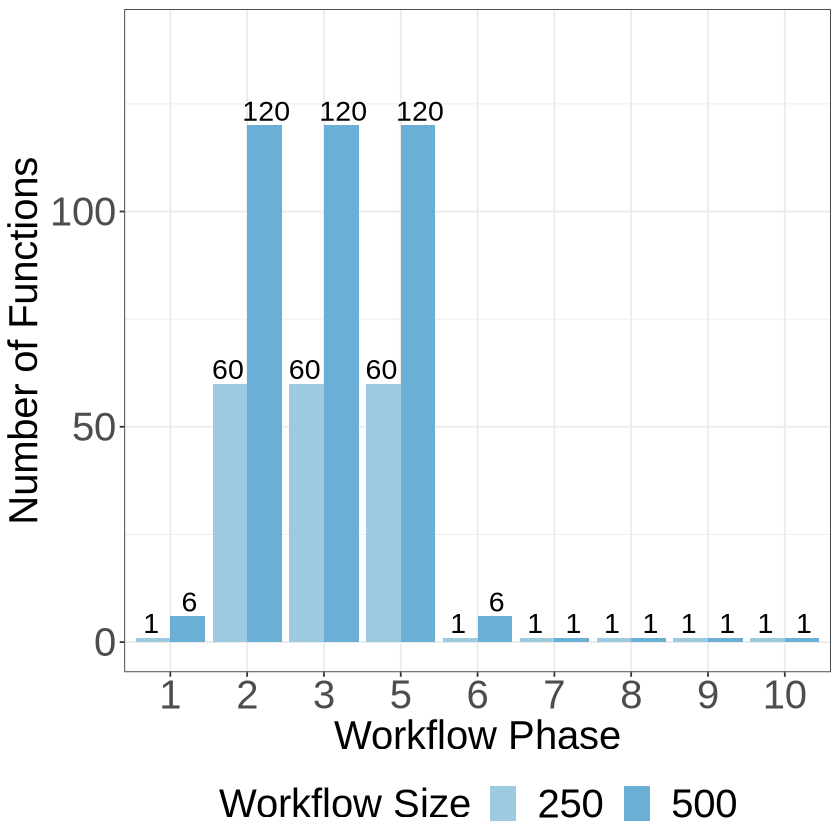

In [9]:
df_plot <- df_all_functions_invocation %>% filter(name == 'EpigenomicsRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        expand_limits(y = max(df_plot$functions) + 20) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_EpigenomicsRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

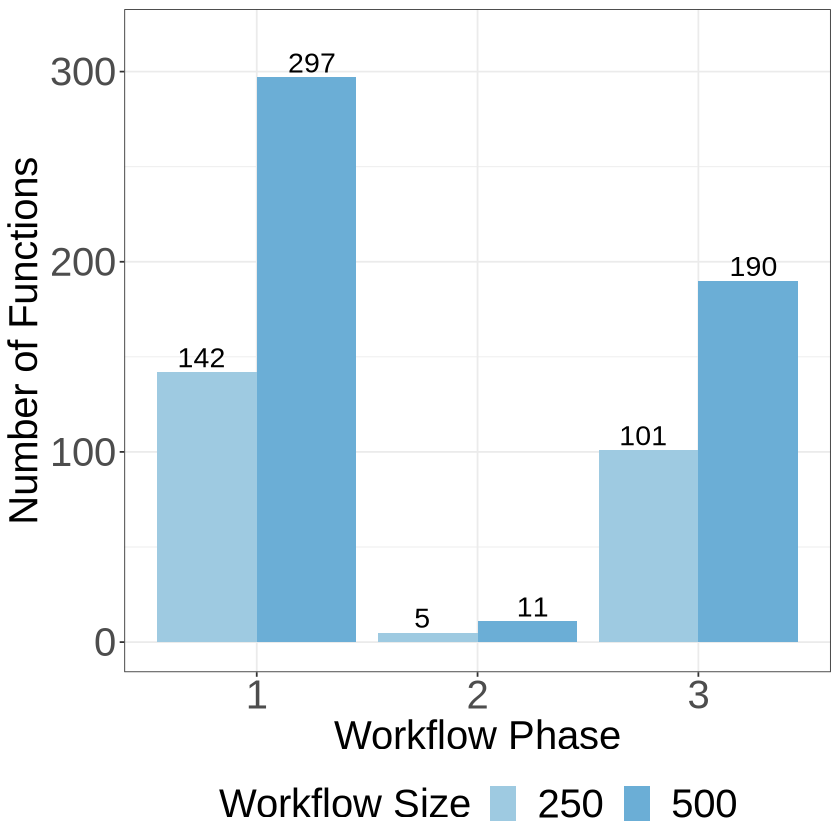

In [10]:
df_plot <- df_all_functions_invocation %>% filter(name == 'GenomeRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        expand_limits(y = max(df_plot$functions) + 20) +        
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_GenomeRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

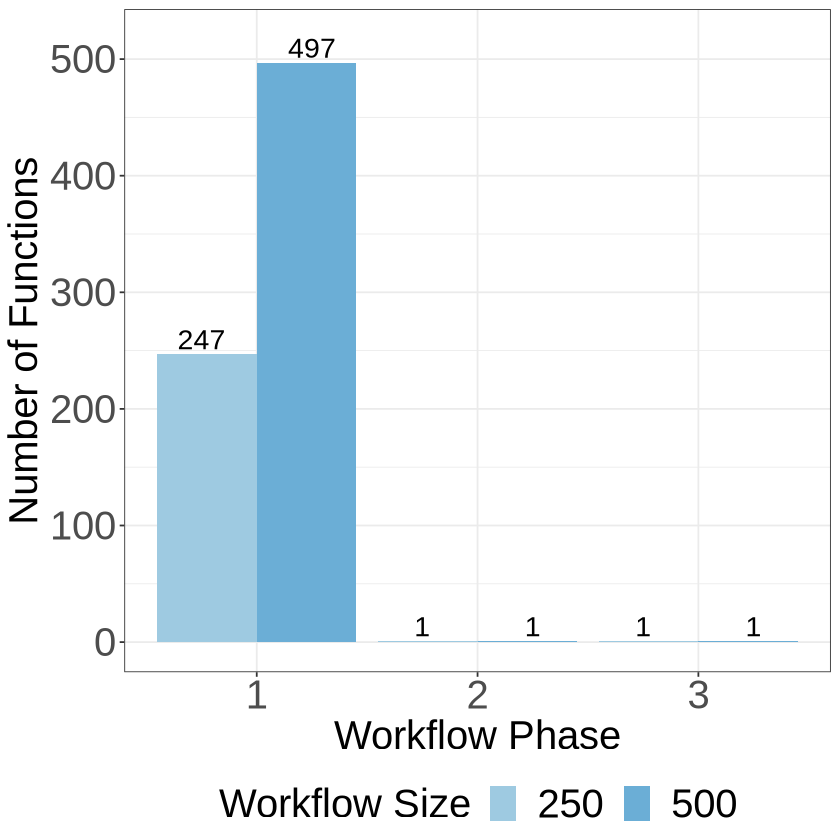

In [11]:
df_plot <- df_all_functions_invocation %>% filter(name == 'SeismologyRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        expand_limits(y = max(df_plot$functions) + 20) +        
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_SeismologyRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

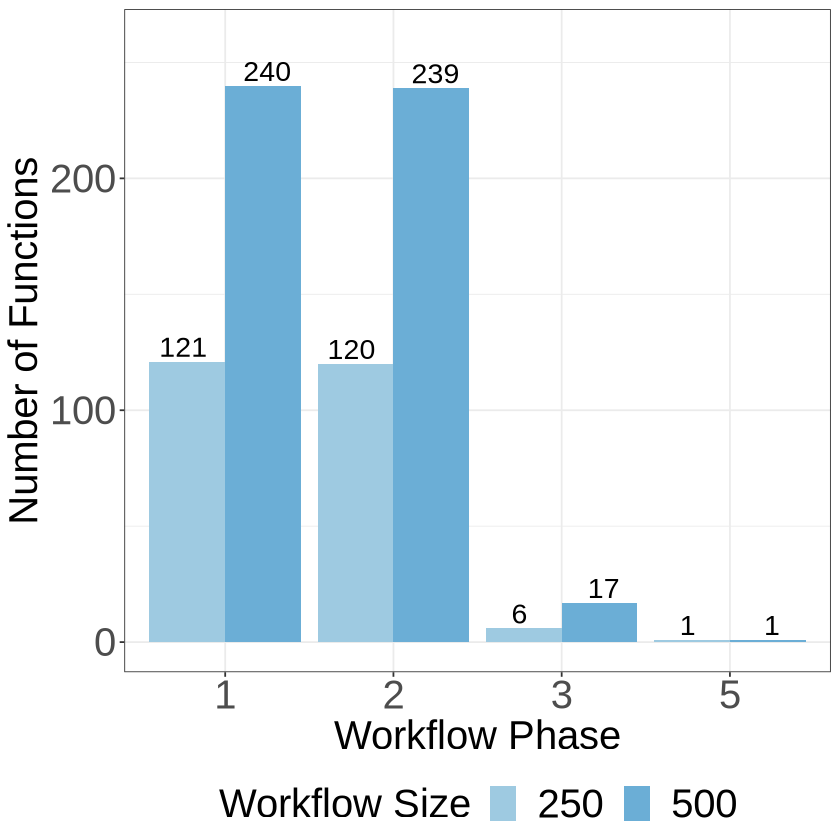

In [12]:
df_plot <- df_all_functions_invocation %>% filter(name == 'SrasearchRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$functions) + 20) +
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_SrasearchRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

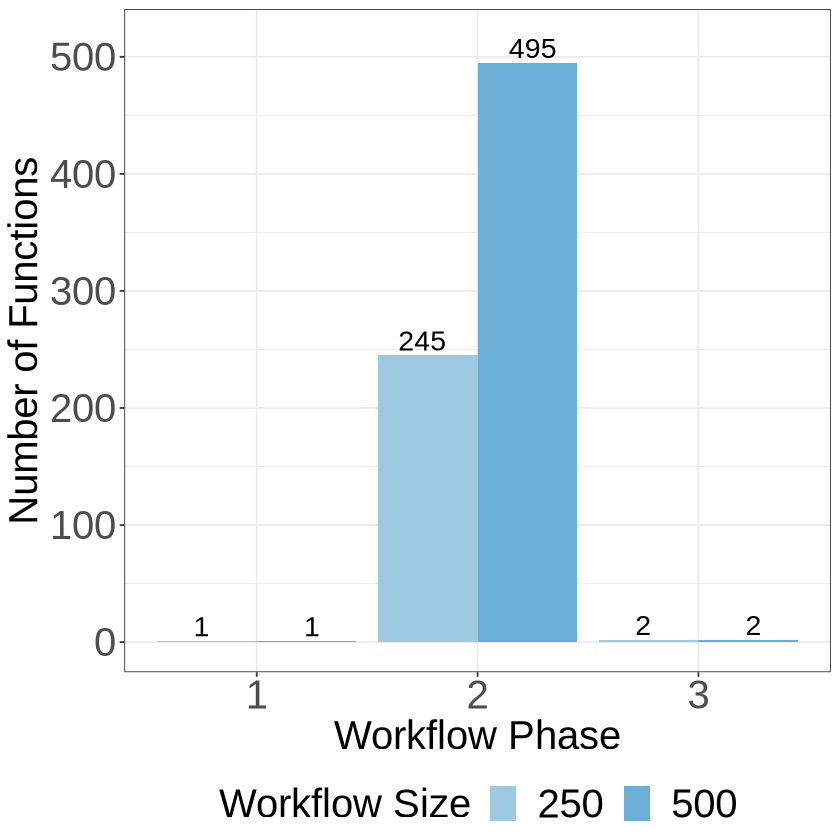

In [13]:
df_plot <- df_all_functions_invocation %>% filter(name == 'BlastRecipe' & phase != 0 & phase != 4)
ggplot(df_plot,
        aes(x = as.factor(phase), y = functions, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        #facet_wrap(. ~ as.factor(df_plot$name), scales='free_y', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$functions) + 20) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_BlastRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

In [14]:
df_all_functions_invocation_name <- read_and_bind_all_files(
    paste('./wfbench/csv/functions_invocation_name/',sep=','))
names(df_all_functions_invocation_name) <- c("function_name","invocations","name", "size")

df_all_functions_invocation_name <- df_all_functions_invocation_name %>% 
    filter(!str_detect(function_name, 'start')) %>%
    filter(!str_detect(function_name, 'finish'))

head(df_all_functions_invocation_name)
tail(df_all_functions_invocation_name)
#print(df_all_functions_invocation_name)

function_name invocations name        size
1 split           1         BlastRecipe 250 
2 blastall      245         BlastRecipe 250 
3 cat             2         BlastRecipe 250 
4 split           1         BlastRecipe 500 
5 blastall      495         BlastRecipe 500 
6 cat             2         BlastRecipe 500

function_name invocations name            size
1 bowtie2       120         SrasearchRecipe 250 
2 merge           7         SrasearchRecipe 250 
3 bowtie2-build   1         SrasearchRecipe 500 
4 fasterq-dump  239         SrasearchRecipe 500 
5 bowtie2       239         SrasearchRecipe 500 
6 merge          18         SrasearchRecipe 500

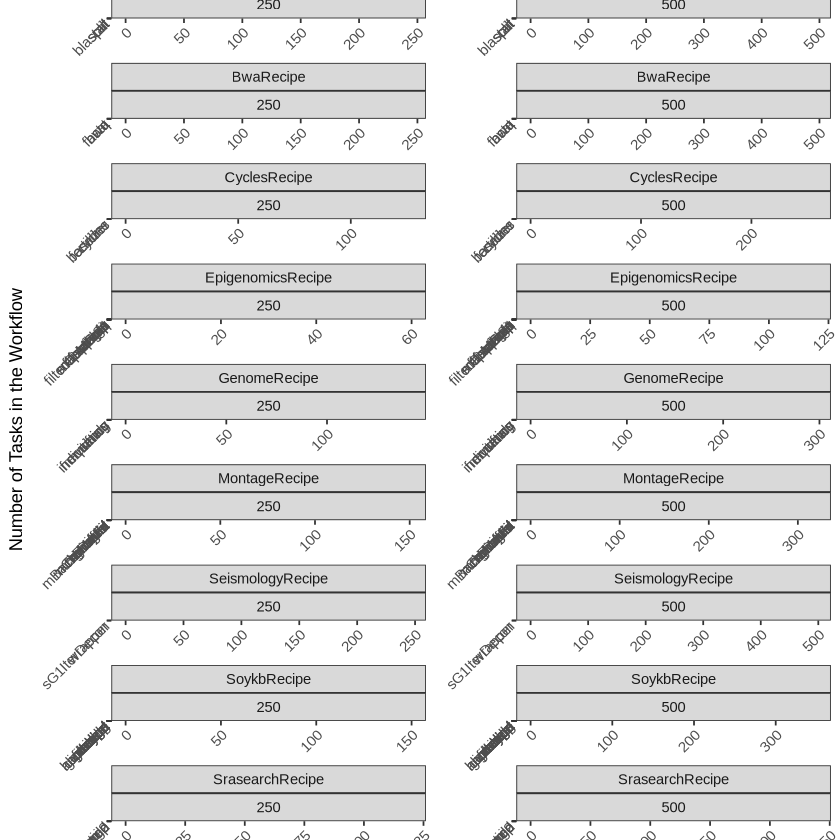

In [15]:
df_plot <- df_all_functions_invocation_name
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations)) +
        geom_bar(stat="identity", position=position_dodge()) +
        facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        labs(x = "Number of Tasks in the Workflow", y = "Powe Consumption (W)", fill = "Workflows") +
        theme_bw() +
        theme(
            #strip.text.x = element_text(size=26),
            legend.position= "bottom",
            #axis.text=element_text(size=24),
            #axis.title=element_text(size=28),
            #legend.title=element_text(size=20), 
            #legend.text=element_text(size=20),
            axis.text.y = element_text(angle = 45, vjust = 1, hjust=1),
            axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        coord_flip() + 
        guides(color=guide_legend(nrow=2,byrow=TRUE, title.position = "top"))
        ggsave("df_all_functions_invocation_name.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

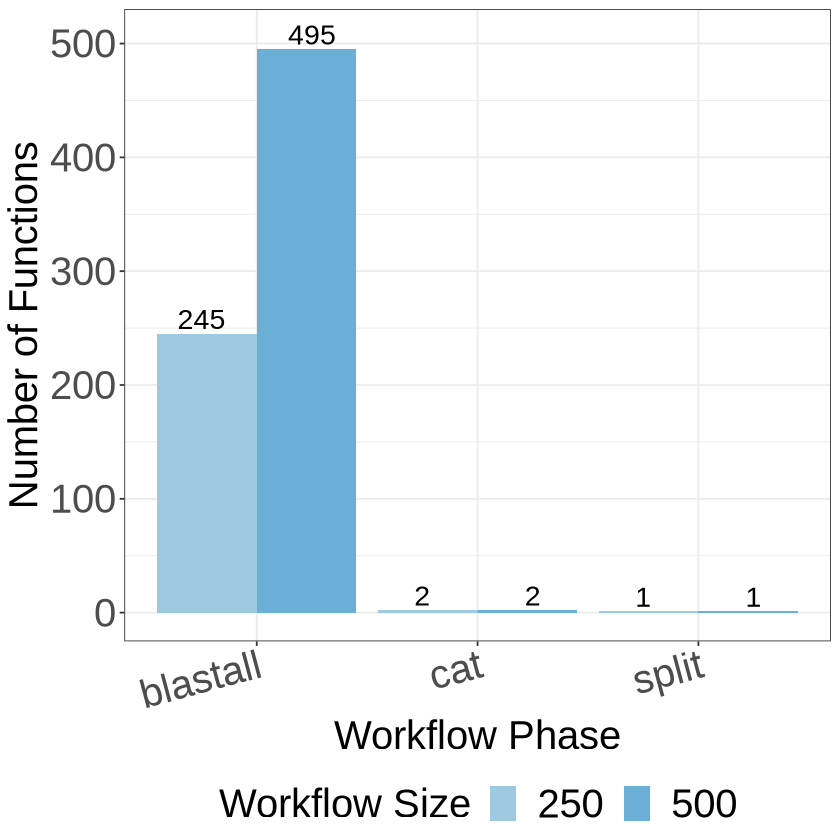

In [16]:
df_plot <- df_all_functions_invocation_name %>% filter(name == 'BlastRecipe')
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_text(aes(label=round(invocations, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        #facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$invocations) + 10) +
        labs(x = "Functions' Name", y = "Number of Functions", fill = "Workflow Sizes") +
        #geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24),
                axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_name_BlastRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

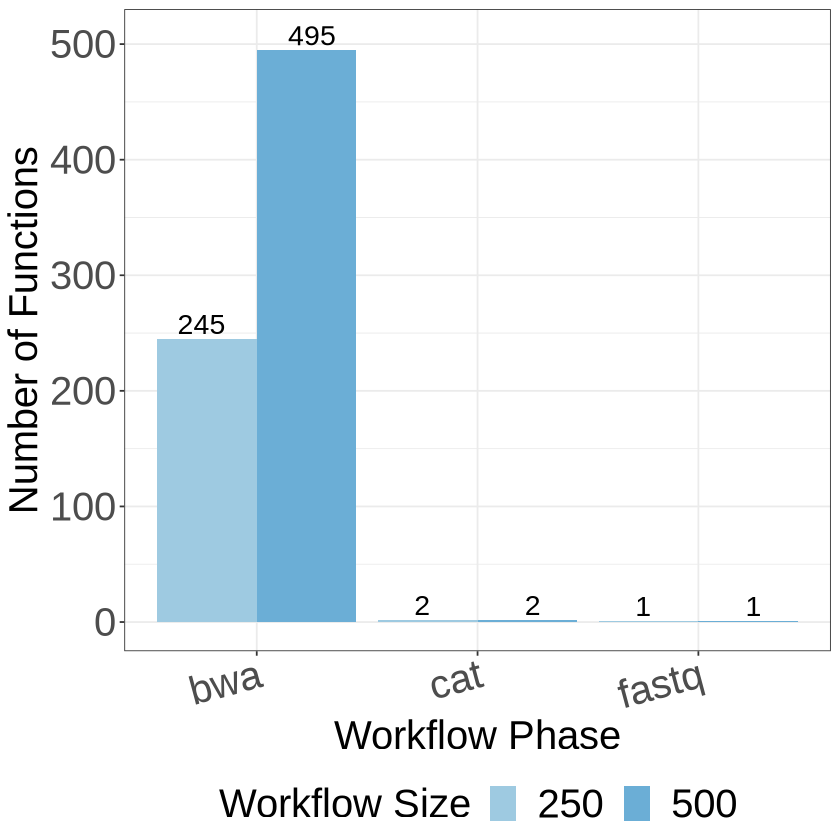

In [17]:
df_plot <- df_all_functions_invocation_name %>% filter(name == 'BwaRecipe')
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_text(aes(label=round(invocations, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        #facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$invocations) + 10) +
        labs(x = "Functions' Name", y = "Number of Functions", fill = "Workflow Sizes") +
        #geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        labs(x = "Workflow Phase", y = "Number of Functions", fill = "Workflow Size") +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24),
                axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_name_BwaRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

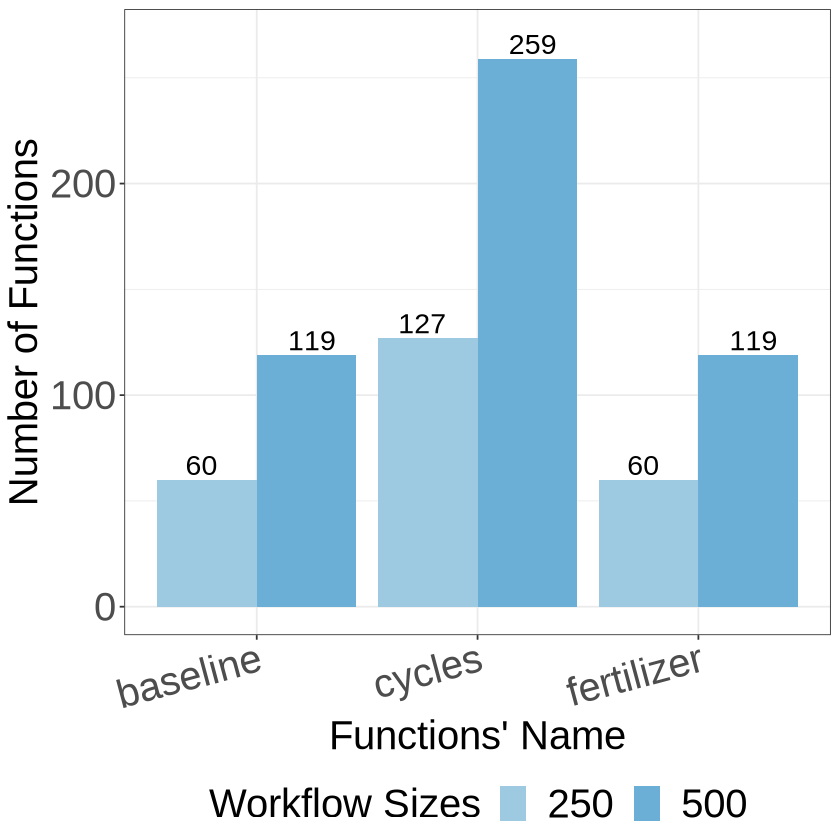

In [18]:
df_plot <- df_all_functions_invocation_name %>% filter(name == 'CyclesRecipe')
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_text(aes(label=round(invocations, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        #facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$invocations) + 10) +
        labs(x = "Functions' Name", y = "Number of Functions", fill = "Workflow Sizes") +
        #geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24),
                axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_name_CyclesRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

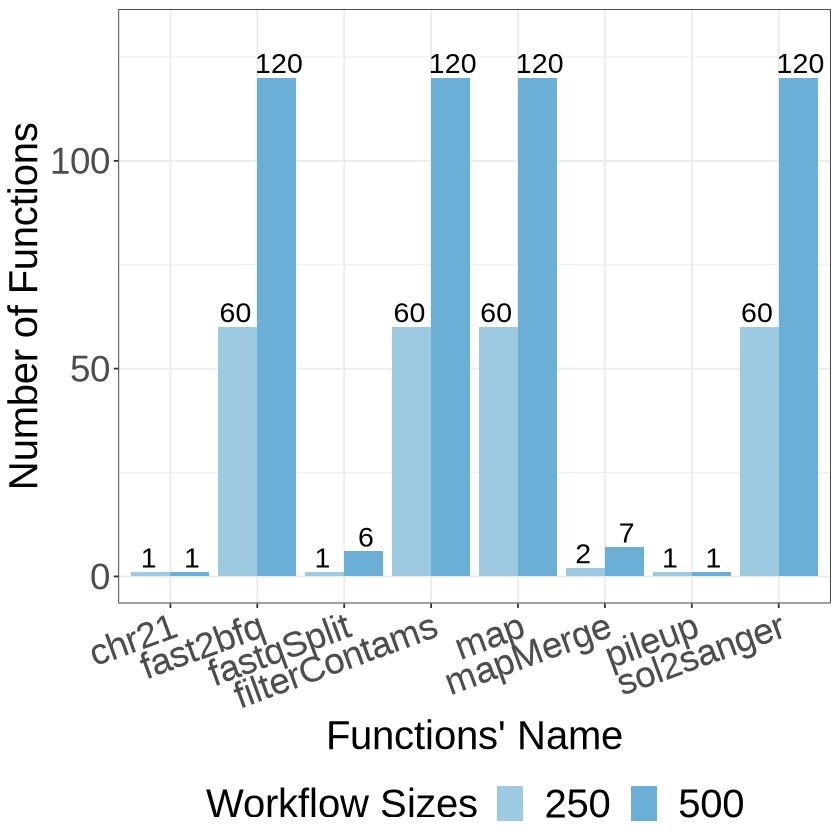

In [19]:
df_plot <- df_all_functions_invocation_name %>% filter(name == 'EpigenomicsRecipe')
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_text(aes(label=round(invocations, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        #facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$invocations) + 10) +
        labs(x = "Functions' Name", y = "Number of Functions", fill = "Workflow Sizes") +
        #geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=22),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24),
                axis.text.x = element_text(angle = 20, vjust = 1, hjust=1)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_name_EpigenomicsRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

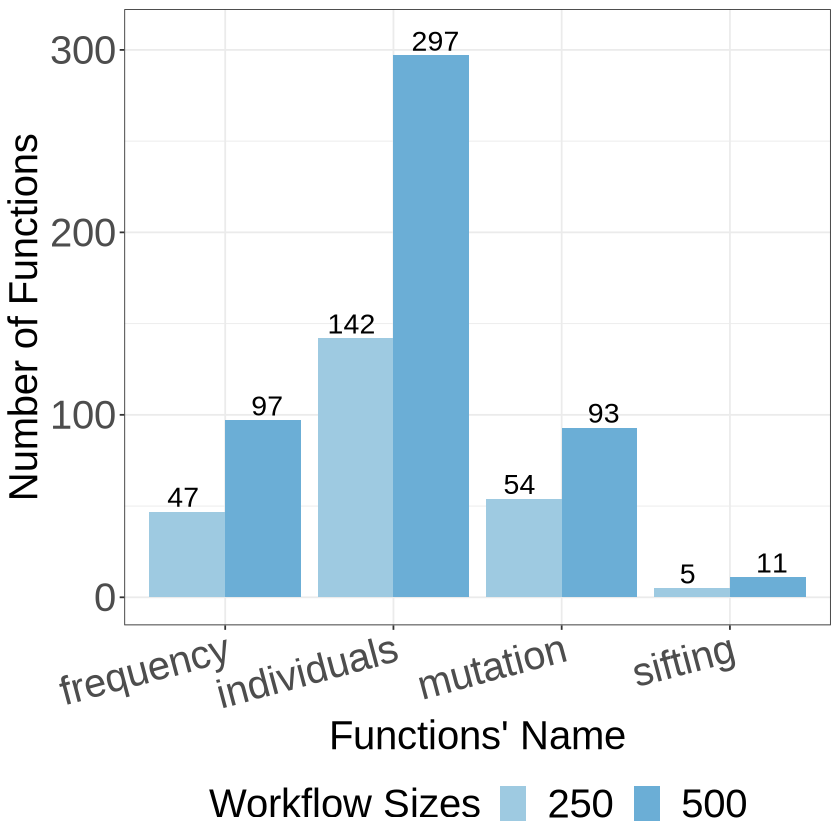

In [20]:
df_plot <- df_all_functions_invocation_name %>% filter(name == 'GenomeRecipe')
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_text(aes(label=round(invocations, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        #facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$invocations) + 10) +
        labs(x = "Functions' Name", y = "Number of Functions", fill = "Workflow Sizes") +
        #geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24),
                axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_name_GenomeRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

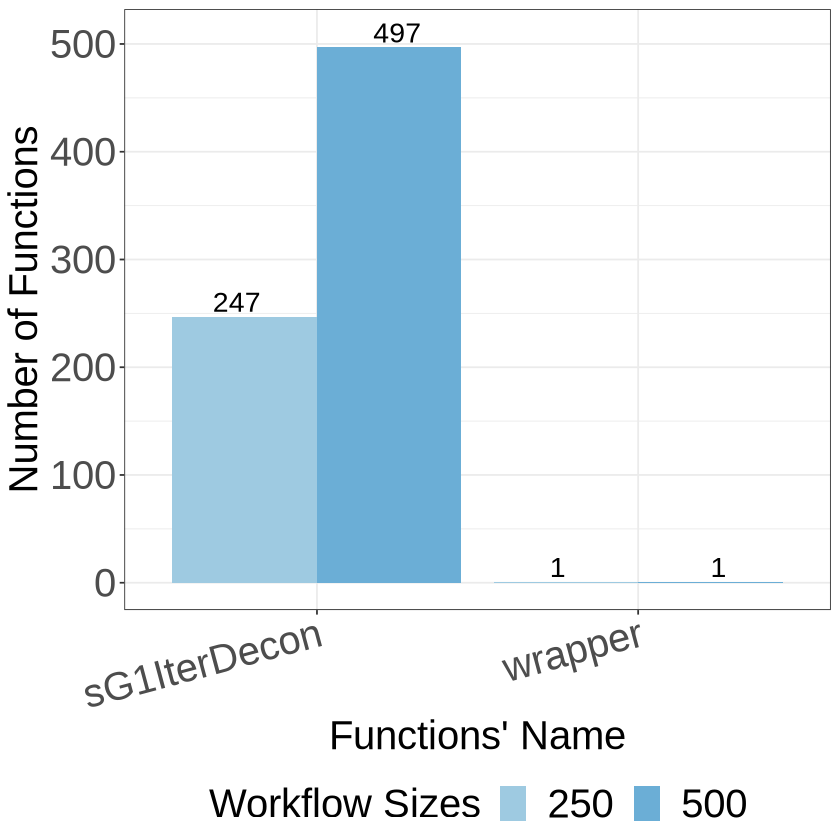

In [21]:
df_plot <- df_all_functions_invocation_name %>% filter(name == 'SeismologyRecipe')
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_text(aes(label=round(invocations, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        #facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$invocations) + 10) +
        labs(x = "Functions' Name", y = "Number of Functions", fill = "Workflow Sizes") +
        #geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24),
                axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_name_SeismologyRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)

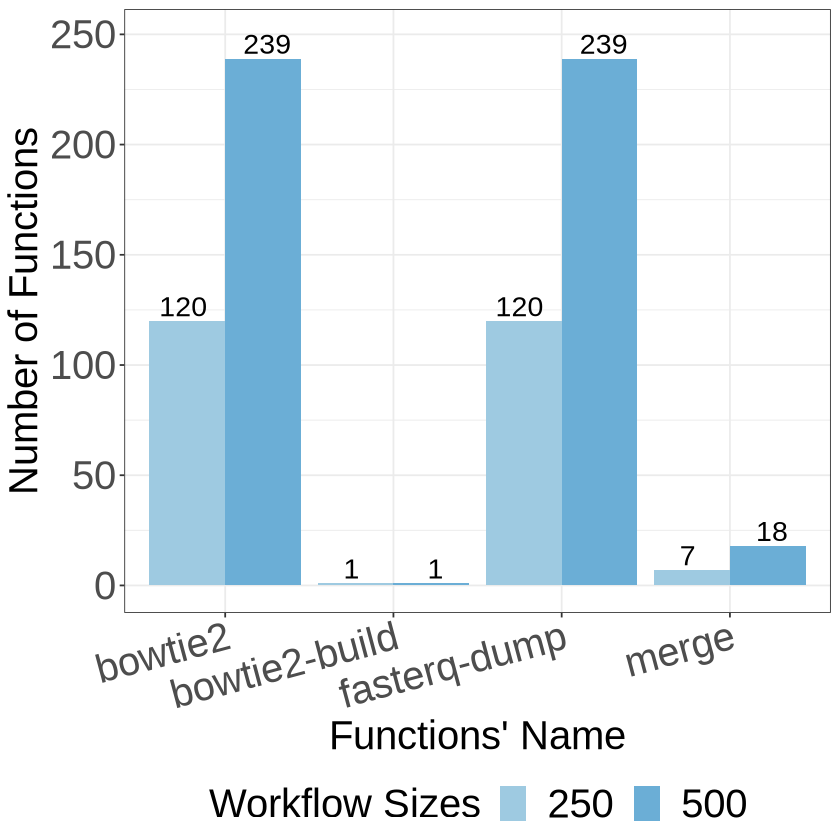

In [22]:
df_plot <- df_all_functions_invocation_name %>% filter(name == 'SrasearchRecipe')
ggplot(df_plot,
        aes(x = as.factor(function_name), y = invocations, fill = as.factor(df_plot$size))) +
        geom_bar(stat="identity", position=position_dodge()) +
        geom_text(aes(label=round(invocations, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        #facet_wrap(as.factor(df_plot$name) ~ as.factor(df_plot$size), scales='free', ncol=2) +
        #scale_fill_manual(values=palette_colors, breaks=c('250', '500', '1000')) +
        #scale_color_discrete() + 
        expand_limits(y = max(df_plot$invocations) + 10) +
        labs(x = "Functions' Name", y = "Number of Functions", fill = "Workflow Sizes") +
        #geom_text(aes(label=round(functions, digits = 2)), position=position_dodge(width=1), vjust=-0.25, size = 6) +
        scale_fill_manual(values=palette_colors) +#labels=label_scenarios) +
        theme_bw() +
        theme(
                strip.text.x = element_text(size=22),
                legend.position= "bottom",
                axis.text=element_text(size=24),
                axis.title=element_text(size=24),
                legend.title=element_text(size=24), 
                legend.text=element_text(size=24),
                axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
        guides(
                shape=guide_legend(nrow=1,byrow=TRUE),
                color=guide_legend(nrow=1,byrow=TRUE))
        ggsave("df_all_functions_invocation_name_SrasearchRecipe.png", width = 8, height = 6, units = "in") #+ 
        #ggsave("makespan_per_heterogeneity.pdf", width = 14, height = 12)